In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

In [7]:
se_dates = source[["start", "end"]]
se_dates[~se_dates.duplicated()].sort_values(by="start")

,start,end
0,2020-09-05,2020-09-11
158,2020-10-23,2020-10-28
249,2020-11-03,2020-11-07
113,2020-11-14,2020-11-18
124,2020-11-24,2020-11-28
2,2020-11-29,2020-11-29
254,2020-12-04,2020-12-14
196,2020-12-16,2020-12-24
376,2021-01-12,2021-01-21


In [8]:
# wr = pd.read_csv("../data/weather/weather_report_2709555247418929082.csv", parse_dates=["Date"])
# wr = pd.read_csv("../data/weather/weather_report_1620322523.634392.csv", parse_dates=["Date"])
wr = pd.read_csv("../data/weather/weather_report_1620408982.771627.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [9]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [10]:
wr["Time"] = wr["Date"] + wr["Hour"]

# PyOD

In [11]:
import pyod
from pyod.models.copod import COPOD

In [12]:
wr = pd.read_csv("../data/weather/weather_report_2709555247418929082.csv")
hly_cols = wr.columns[wr.columns.str.contains("Hly")]
wr_train = wr[hly_cols].dropna(axis=1, how="all").dropna(axis=0, how="any")

In [14]:
clf = COPOD()
clf.fit(wr_train)
outlier_scores = clf.decision_scores_
outlier_scores = pd.Series(clf.decision_scores_, index=wr_train.index)

In [15]:
outlier_scores.describe(percentiles=np.arange(0,1,.01))

count    1990.000000
mean       14.069710
std         5.334305
min         7.178627
0%          7.178627
            ...     
96%        26.066235
97%        27.840614
98%        30.048138
99%        32.792862
max        45.072450
Length: 105, dtype: float64

In [16]:
wr_outliers = wr.iloc[wr_train[outlier_scores > 25].index]

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
443,2020-12-07,342,1200,6,english,"95618, 95617, 95616",hourly,66.2,30.6,0.02,...,0.02,NaN,0.00,26.0,16.0,49.1,953.0,5.8,275.0,16.2
591,2020-12-13,348,1600,6,english,"95618, 95617, 95616",hourly,52.3,52.0,0.00,...,0.00,NaN,0.09,99.0,9.2,50.0,73.0,13.2,97.0,9.2
708,2021-01-13,13,1300,6,english,"95618, 95617, 95616",hourly,60.7,53.7,0.01,...,0.01,NaN,0.00,78.0,5.8,50.9,759.0,14.1,355.0,6.1
824,2021-01-18,18,900,6,english,"95618, 95617, 95616",hourly,62.2,19.0,0.01,...,0.02,NaN,0.00,19.0,22.1,49.9,314.0,3.6,342.0,22.4
825,2021-01-18,18,1000,6,english,"95618, 95617, 95616",hourly,64.5,18.1,0.02,...,0.02,NaN,0.00,16.0,20.9,49.9,668.0,3.4,346.0,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,2020-12-14,349,1200,251,english,"92346, 92374",hourly,61.6,26.7,0.02,...,0.02,NaN,0.00,26.0,10.4,52.6,1029.0,4.9,342.0,11.0
1763,2020-12-06,341,1200,250,english,"95987, 95955, 95932, 95912",hourly,64.3,35.5,0.02,...,0.02,NaN,0.00,34.0,14.9,49.2,1007.0,7.0,350.0,15.2
1786,2020-12-07,342,1100,250,english,"95987, 95955, 95932, 95912",hourly,64.5,31.2,0.02,...,0.02,NaN,0.00,28.0,19.1,50.5,838.0,5.9,347.0,19.4
1787,2020-12-07,342,1200,250,english,"95987, 95955, 95932, 95912",hourly,67.4,30.6,0.02,...,0.02,NaN,0.00,25.0,18.1,50.5,952.0,5.8,344.0,18.5


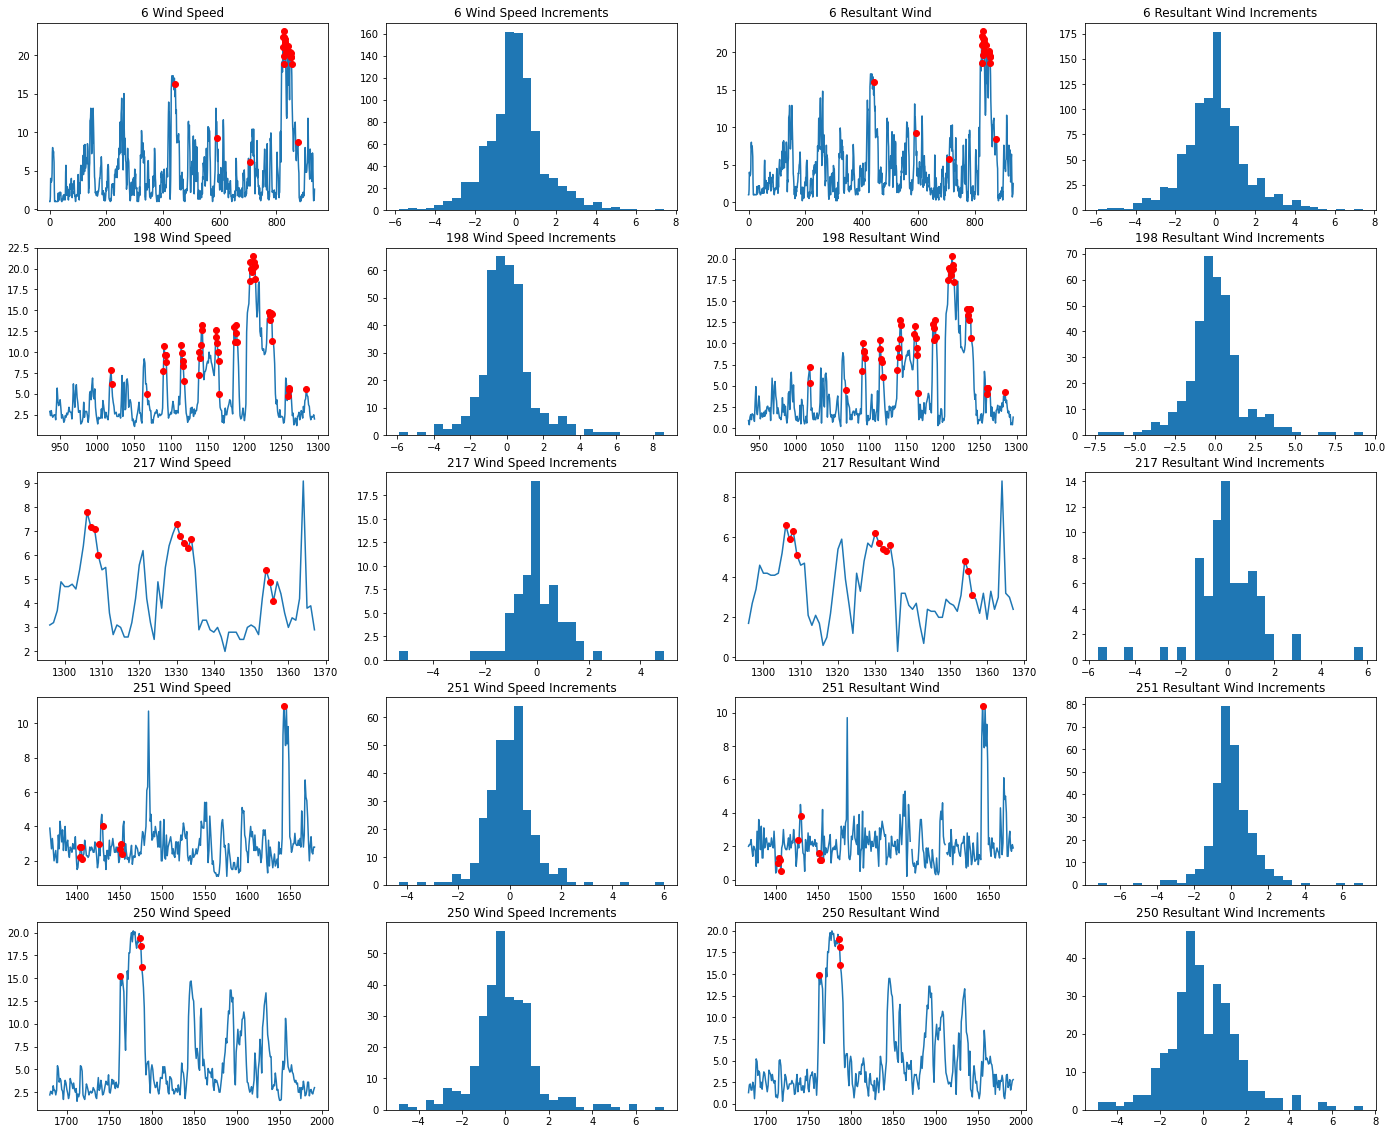

In [17]:
stations = wr.Station.unique()
fig, ax = plt.subplots(5,4,figsize=(24,20))
for (s, v_ax) in zip(stations[:-1], ax):
        wrs = wr[wr.Station==s]
        v_ax[0].plot(wrs["HlyWindSpd (MPH)"])
        v_ax[0].plot(wr_outliers[wr_outliers.Station == s]["HlyWindSpd (MPH)"], 'o', color="red")
        v_ax[0].set_title("{} Wind Speed".format(s))
        
        v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
        v_ax[1].set_title("{} Wind Speed Increments".format(s))
        
        v_ax[2].plot(wrs["HlyResWind (MPH)"])
        v_ax[2].plot(wr_outliers[wr_outliers.Station == s]["HlyResWind (MPH)"], 'o', color="red")
        v_ax[2].set_title("{} Resultant Wind".format(s))
        
        v_ax[3].hist(wrs["HlyResWind (MPH)"].diff(), bins=30)
        v_ax[3].set_title("{} Resultant Wind Increments".format(s))

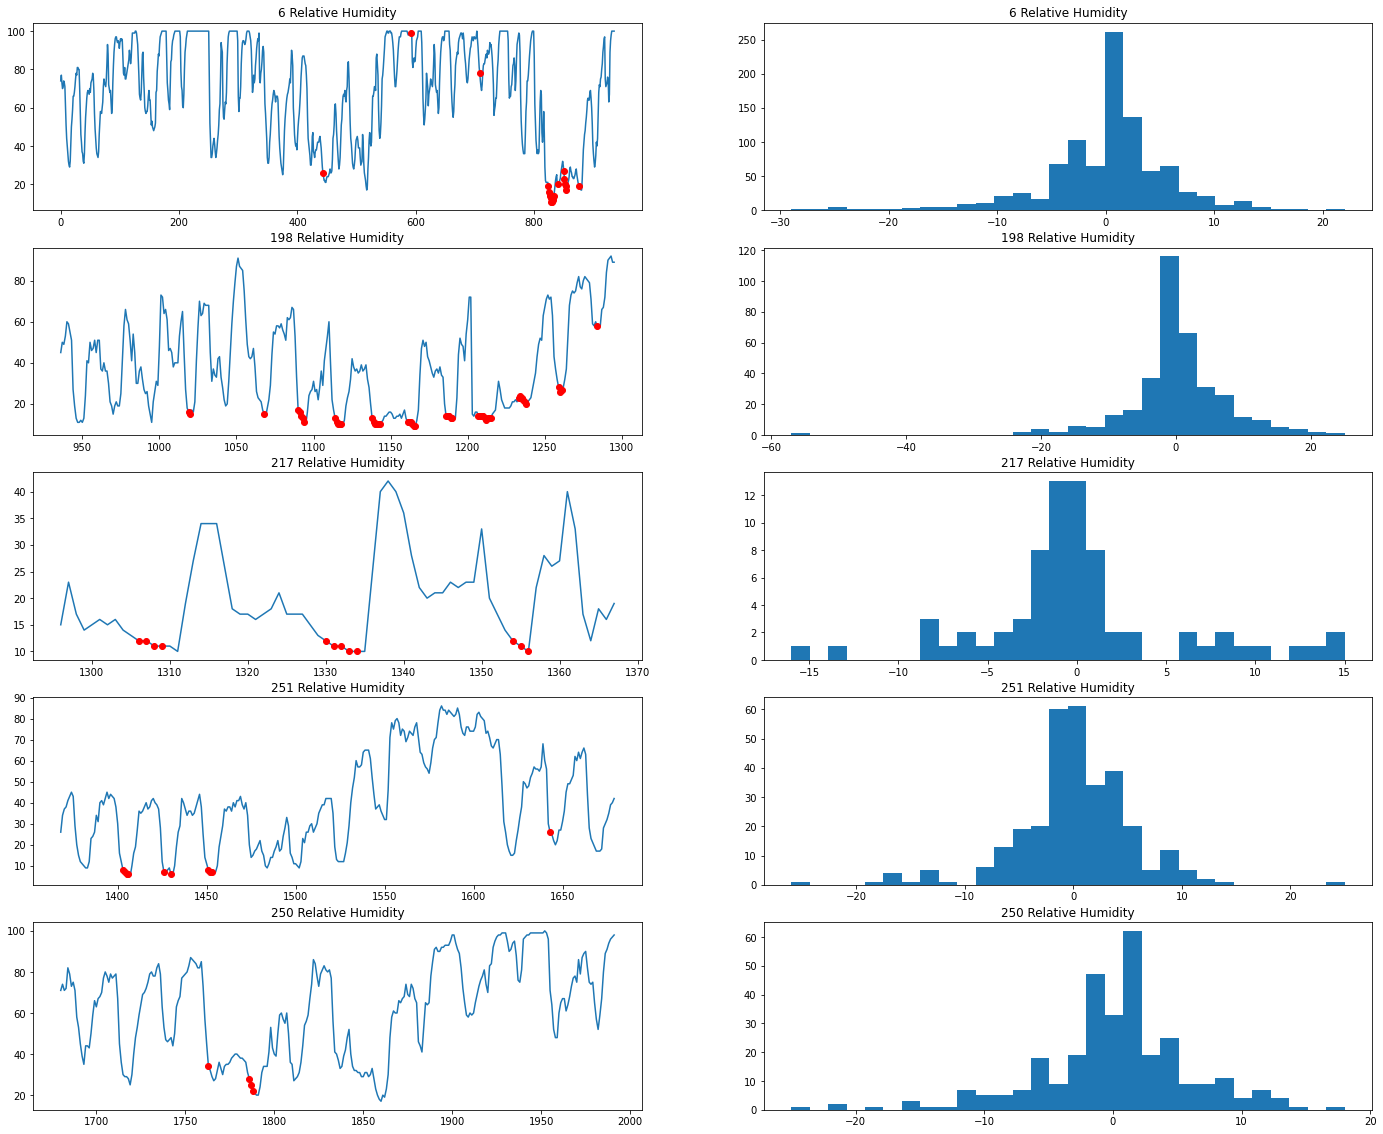

In [18]:
stations = wr.Station.unique()
fig, ax = plt.subplots(5,2,figsize=(24,20))
for (s, v_ax) in zip(stations[:-1], ax):
        wrs = wr[wr.Station==s]
        v_ax[0].plot(wrs["HlyRelHum (%)"])
        v_ax[0].plot(wr_outliers[wr_outliers.Station == s]["HlyRelHum (%)"], 'o', color="red")
        v_ax[0].set_title("{} Relative Humidity".format(s))
        
        v_ax[1].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
        v_ax[1].set_title("{} Relative Humidity".format(s))

# Banpei

In [11]:
import banpei

In [12]:
model = banpei.SST(w=10)

In [25]:
wr_sample = wr.loc[wr.Station==6, "HlyWindSpd (MPH)"]

0      1.0
1      1.0
2      1.7
3      4.0
4      3.7
      ... 
931    2.1
932    1.1
933    1.3
934    1.2
935    2.6
Name: HlyWindSpd (MPH), Length: 936, dtype: float64

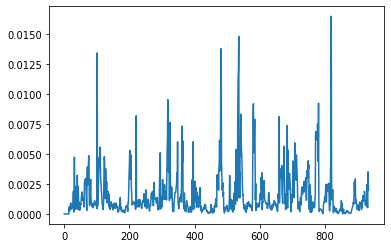

In [14]:
outlier_scores = pd.Series(model.detect(wr_sample))
plt.plot(outlier_scores)

In [17]:
outlier_scores.describe(percentiles=np.arange(0,1,.05))

count    936.000000
mean       0.001551
std        0.001910
min        0.000000
0%         0.000000
5%         0.000119
10%        0.000202
15%        0.000288
20%        0.000385
25%        0.000475
30%        0.000572
35%        0.000632
40%        0.000722
45%        0.000813
50%        0.000893
55%        0.000986
60%        0.001118
65%        0.001283
70%        0.001560
75%        0.001863
80%        0.002292
85%        0.002852
90%        0.003612
95%        0.005297
max        0.016458
dtype: float64

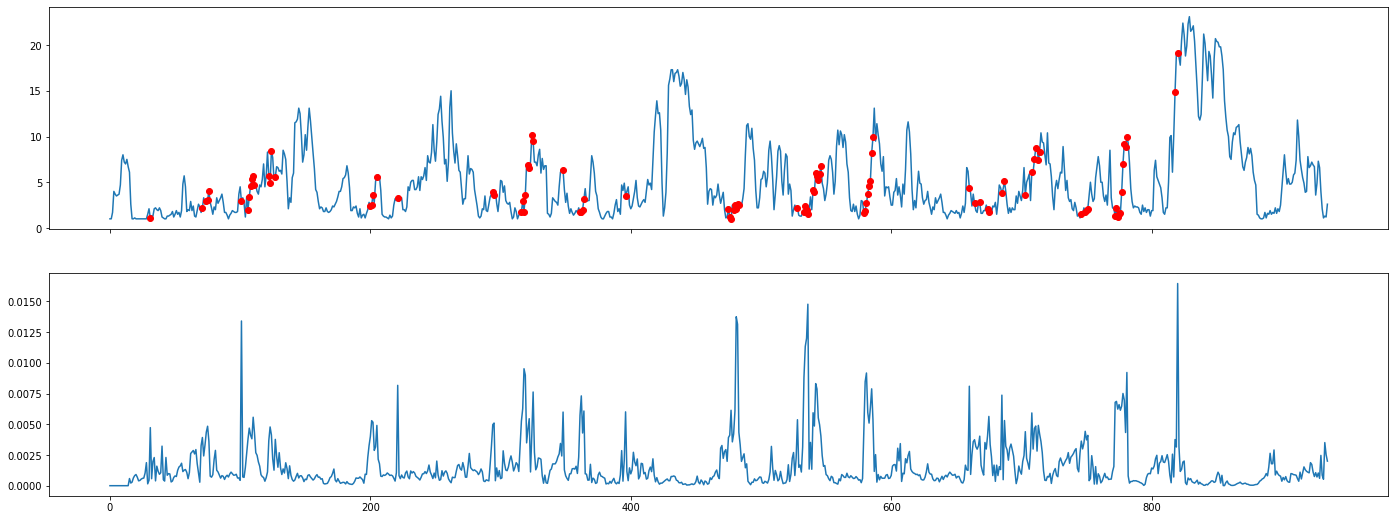

In [22]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(24,9))
ax[0].plot(wr_sample)
ax[0].plot(wr_sample[outlier_scores>outlier_scores.describe(percentiles=np.arange(0,1,.05))["90%"]], 'o', color="red")
ax[1].plot(outlier_scores)

# ADTK

In [7]:
import adtk

In [111]:
wr_adtk = wr[wr.Station==6][["Time", "HlyWindSpd (MPH)"]]
wr_adtk.set_index("Time", inplace=True)

In [112]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(wr_adtk)

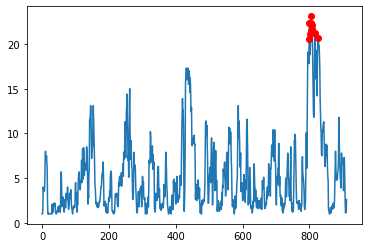

In [113]:
plt.plot(wr_adtk.values)
plt.plot(wr_adtk[anomalies].values, 'o', color='red')

In [129]:
wr_adtk = wr[wr.Station==6][["Time", "HlyRelHum (%)", "HlyWindSpd (MPH)"]]
wr_adtk.set_index("Time", inplace=True)
wr_adtk.head()

,HlyRelHum (%),HlyWindSpd (MPH)
Time,,
2020-11-28 01:00:00,74.0,1.0
2020-11-28 02:00:00,77.0,1.0
2020-11-28 03:00:00,73.0,1.7
2020-11-28 04:00:00,70.0,4.0
2020-11-28 05:00:00,71.0,3.7


In [130]:
from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(wr_adtk)

Text(0.5, 1.0, 'Wind Speed')

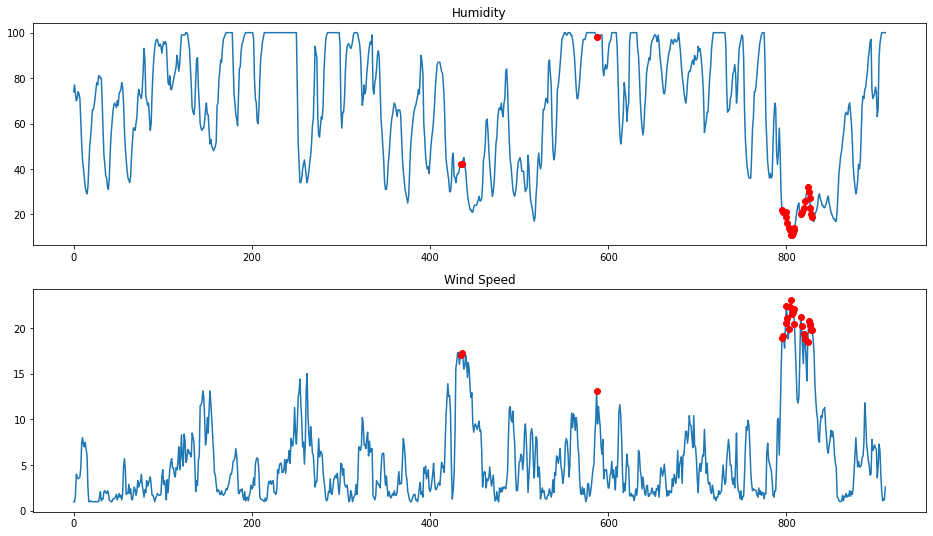

In [145]:
wr_adtk.reset_index(drop=True, inplace=True)
fig, ax = plt.subplots(2,1, figsize=(16,9))
ax[0].plot(wr_adtk["HlyRelHum (%)"])
ax[0].plot(wr_adtk[anomalies.values]["HlyRelHum (%)"], 'o', color='red')
ax[0].set_title("Humidity")

ax[1].plot(wr_adtk["HlyWindSpd (MPH)"])
ax[1].plot(wr_adtk[anomalies.values]["HlyWindSpd (MPH)"], 'o', color='red')
ax[1].set_title("Wind Speed")